## BO with BAxUS and TS/EI

In this tutorial, we show how to implement **B**ayesian optimization with **a**daptively e**x**panding s**u**bspace**s** (BAxUS) [1] in a closed loop in BoTorch.
The tutorial is purposefully similar to the [TuRBO tutorial](https://botorch.org/docs/tutorials/turbo_1) to highlight the differences in the implementations.

This implementation supports either Expected Improvement (EI) or Thompson sampling (TS). We optimize the Branin2 function [2] with 498 dummy dimensions and show that BAxUS outperforms EI as well as Sobol.

Since BoTorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_{x\in \mathcal{X}} -f(x)=0$.

- [1]: [Papenmeier, Leonard, et al. Increasing the Scope as You Learn: Adaptive Bayesian Optimization in Nested Subspaces. Advances in Neural Information Processing Systems. 2022](https://openreview.net/pdf?id=e4Wf6112DI)
- [2]: [Branin Test Function](https://www.sfu.ca/~ssurjano/branin.html)


In [1]:
# Install dependencies if we are running in colab
import sys

if "google.colab" in sys.modules:
    %pip install botorch

In [2]:
import math
import os
from dataclasses import dataclass

import botorch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine

from botorch.acquisition.analytic import LogExpectedImprovement
from botorch.exceptions import ModelFittingError
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.test_functions import Branin

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
Running on cpu


## Optimize the augmented Branin function

The goal is to minimize the embedded Branin function

$f(x_1, x_2, \ldots, x_{20}) = \left (x_2-\frac{5.1}{4\pi^2}x_1^2+\frac{5}{\pi}x_1-6\right )^2+10\cdot \left (1-\frac{1}{8\pi}\right )\cos(x_1)+10$

with bounds [-5, 10] for $x_1$ and [0, 15] for $x_2$ (all other dimensions are ignored). The function has three minima with an optimal value of $0.397887$.

As mentioned above, since botorch assumes a maximization problem, we instead maximize $-f(x)$.

## Define a function with dummy variables

We first define a new function where we only pass the first two input dimensions to the actual Branin function.

In [3]:
branin = Branin(negate=True).to(device=device, dtype=dtype)


def branin_emb(x):
    """x is assumed to be in [-1, 1]^D"""
    lb, ub = branin.bounds
    return branin(lb + (ub - lb) * (x[..., :2] + 1) / 2)

In [4]:
fun = branin_emb
dim = 500 if not SMOKE_TEST else 50

n_init = 10 if not SMOKE_TEST else 4
max_cholesky_size = float("inf")  # Always use Cholesky

## Maintain the BAxUS state
BAxUS needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc. 
In contrast to TuRBO, the failure tolerance depends on the target dimensionality.

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation. 

**Note**: These settings assume that the domain has been scaled to $[-1, 1]^d$

In [5]:
@dataclass
class BaxusState:
    dim: int
    eval_budget: int
    new_bins_on_split: int = 3
    d_init: int = float("nan")  # Note: post-initialized
    target_dim: int = float("nan")  # Note: post-initialized
    n_splits: int = float("nan")  # Note: post-initialized
    length: float = 0.8
    length_init: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    success_counter: int = 0
    success_tolerance: int = 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        n_splits = round(math.log(self.dim, self.new_bins_on_split + 1))
        self.d_init = 1 + np.argmin(
            np.abs(
                (1 + np.arange(self.new_bins_on_split))
                * (1 + self.new_bins_on_split) ** n_splits
                - self.dim
            )
        )
        self.target_dim = self.d_init
        self.n_splits = n_splits

    @property
    def split_budget(self) -> int:
        return round(
            -1
            * (self.new_bins_on_split * self.eval_budget * self.target_dim)
            / (self.d_init * (1 - (self.new_bins_on_split + 1) ** (self.n_splits + 1)))
        )

    @property
    def failure_tolerance(self) -> int:
        if self.target_dim == self.dim:
            return self.target_dim
        k = math.floor(math.log(self.length_min / self.length_init, 0.5))
        split_budget = self.split_budget
        return min(self.target_dim, max(1, math.floor(split_budget / k)))


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

## Create a BAxUS embedding

We now show how to create the BAxUS embedding. The essential idea is to assign input dimensions to target dimensions and to assign a sign $\in \pm 1$ to each input dimension, similar to the HeSBO embedding. 
We create the embedding matrix that is used to project points from the target to the input space. The matrix is sparse, each column has precisely one non-zero entry that is either 1 or -1.

In [6]:
def embedding_matrix(input_dim: int, target_dim: int) -> torch.Tensor:
    if (
        target_dim >= input_dim
    ):  # return identity matrix if target size greater than input size
        return torch.eye(input_dim, device=device, dtype=dtype)

    input_dims_perm = (
        torch.randperm(input_dim, device=device) + 1
    )  # add 1 to indices for padding column in matrix

    bins = torch.tensor_split(
        input_dims_perm, target_dim
    )  # split dims into almost equally-sized bins
    bins = torch.nn.utils.rnn.pad_sequence(
        bins, batch_first=True
    )  # zero pad bins, the index 0 will be cut off later

    mtrx = torch.zeros(
        (target_dim, input_dim + 1), dtype=dtype, device=device
    )  # add one extra column for padding
    mtrx = mtrx.scatter_(
        1,
        bins,
        2 * torch.randint(2, (target_dim, input_dim), dtype=dtype, device=device) - 1,
    )  # fill mask with random +/- 1 at indices

    return mtrx[:, 1:]  # cut off index zero as this corresponds to zero padding


embedding_matrix(10, 3)  # example for an embedding matrix

tensor([[ 0.,  0.,  0.,  0., -1.,  1.,  0.,  0., -1.,  1.],
        [-1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]],
       dtype=torch.float64)

## Function to increase the embedding

Next, we write a helper function to increase the embedding and to bring observations to the increased target space.

In [ ]:
def increase_embedding_and_observations(
    S: torch.Tensor, X: torch.Tensor, n_new_bins: int
) -> torch.Tensor:
    assert X.size(1) == S.size(0), "Observations don't lie in row space of S"

    S_update = S.clone()
    X_update = X.clone()

    for row_idx in range(len(S)):
        row = S[row_idx]
        idxs_non_zero = torch.nonzero(row)
        idxs_non_zero = idxs_non_zero[torch.randperm(len(idxs_non_zero))].reshape(-1)

        if len(idxs_non_zero) <= 1:
            continue

        non_zero_elements = row[idxs_non_zero].reshape(-1)

        n_row_bins = min(
            n_new_bins + 1, len(idxs_non_zero)
        )  # number of new bins is always less than or equal to the contributing input dims in the row minus one

        # The dims in the first bin won't be moved
        # Add 1 to indices before splitting so padding zeros don't collide with index 0
        new_bins = torch.tensor_split(idxs_non_zero + 1, n_row_bins)[1:]
        elements_to_move = torch.tensor_split(non_zero_elements, n_row_bins)[1:]

        new_bins_padded = torch.nn.utils.rnn.pad_sequence(
            new_bins, batch_first=True
        )  # pad the tuples of bins with zeros to apply _scatter
        els_to_move_padded = torch.nn.utils.rnn.pad_sequence(
            elements_to_move, batch_first=True
        )

        S_stack = torch.zeros(
            (n_row_bins - 1, len(row) + 1), device=device, dtype=dtype
        )  # submatrix to stack on S_update

        S_stack = S_stack.scatter_(
            1, new_bins_padded, els_to_move_padded
        )  # fill with old values (column 0 is the padding column)

        S_update[row_idx, torch.hstack(new_bins) - 1] = (
            0  # set values that were moved to zero in current row
        )

        X_update = torch.hstack(
            (X_update, X[:, row_idx].reshape(-1, 1).repeat(1, len(new_bins)))
        )  # repeat observations for row at the end of X (column-wise)
        S_update = torch.vstack(
            (S_update, S_stack[:, 1:])
        )  # stack onto S_update except for padding column

    return S_update, X_update

In [8]:
S = embedding_matrix(10, 2)
X = torch.randint(100, (7, 2))
print(f"S before increase\n{S}")
print(f"X before increase\n{X}")

S, X = increase_embedding_and_observations(S, X, 3)
print(f"S after increase\n{S}")
print(f"X after increase\n{X}")

S before increase
tensor([[-1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1., -1.]],
       dtype=torch.float64)
X before increase
tensor([[14, 38],
        [49,  8],
        [21, 77],
        [95, 24],
        [33, 57],
        [10, 71],
        [24, 72]])
S after increase
tensor([[ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],
       dtype=torch.float64)
X after increase
tensor([[14, 38, 14, 14, 14, 38, 38, 38],
        [49,  8, 49, 49, 49,  8,  8,  8],
        [21, 77, 21, 21, 21, 77, 77, 77],
        [95, 24, 95

## Take a look at the state

In [9]:
state = BaxusState(dim=dim, eval_budget=500)
print(state)

BaxusState(dim=500, eval_budget=500, new_bins_on_split=3, d_init=np.int64(2), target_dim=np.int64(2), n_splits=4, length=0.8, length_init=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, success_counter=0, success_tolerance=3, best_value=-inf, restart_triggered=False)


## Generate initial points
This generates an initial set of Sobol points that we use to start of the BO loop.

In [10]:
def get_initial_points(dim: int, n_pts: int, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = (
        2 * sobol.draw(n=n_pts).to(dtype=dtype, device=device) - 1
    )  # points have to be in [-1, 1]^d
    return X_init

## Generate new batch
Given the current `state` and a probabilistic (GP) `model` built from observations `X` and `Y`, we generate a new batch of points.  

This method works on the domain $[-1, +1]^d$, so make sure to not pass in observations from the true domain.  `unnormalize` is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the `acqf` argument.

In [11]:
def create_candidate(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [-1, 1]^d
    Y,  # Function values
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= -1.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.lengthscale.detach().view(-1)
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length, -1.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length, -1.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=1)

    elif acqf == "ei":
        ei = LogExpectedImprovement(model, train_Y.max())
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=1,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

## Optimization loop
This simple loop runs one instance of BAxUS with Thompson sampling until convergence.

BAxUS works on a fixed evaluation budget and shrinks the trust region until the minimal trust region size is reached (`state["restart_triggered"]` is set to `True`).
Then, BAxUS increases the target space and carries over the observations to the updated space. 


In [12]:
EVALUATION_BUDGET = 100 if not SMOKE_TEST else 10
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4


state = BaxusState(dim=dim, eval_budget=EVALUATION_BUDGET - n_init)
S = embedding_matrix(input_dim=state.dim, target_dim=state.d_init)

X_baxus_target = get_initial_points(state.d_init, n_init)
X_baxus_input = X_baxus_target @ S
Y_baxus = torch.tensor(
    [branin_emb(x) for x in X_baxus_input], dtype=dtype, device=device
).unsqueeze(-1)


# Disable input scaling checks as we normalize to [-1, 1]
with botorch.settings.validate_input_scaling(False):
    for _ in range(EVALUATION_BUDGET - n_init):  # Run until evaluation budget depleted
        # Fit a GP model
        train_Y = (Y_baxus - Y_baxus.mean()) / Y_baxus.std()
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
        model = SingleTaskGP(X_baxus_target, train_Y, likelihood=likelihood)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        # Do the fitting and acquisition function optimization inside the Cholesky context
        with gpytorch.settings.max_cholesky_size(max_cholesky_size):
            # Fit the model
            try:
                fit_gpytorch_mll(mll)
            except ModelFittingError:
                # Right after increasing the target dimensionality, the covariance matrix becomes indefinite
                # In this case, the Cholesky decomposition might fail due to numerical instabilities
                # In this case, we revert to Adam-based optimization
                optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)

                for _ in range(100):
                    optimizer.zero_grad()
                    output = model(X_baxus_target)
                    loss = -mll(output, train_Y.flatten())
                    loss.backward()
                    optimizer.step()

            # Create a batch
            X_next_target = create_candidate(
                state=state,
                model=model,
                X=X_baxus_target,
                Y=train_Y,
                n_candidates=N_CANDIDATES,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                acqf="ts",
            )

        X_next_input = X_next_target @ S

        Y_next = torch.tensor(
            [branin_emb(x) for x in X_next_input], dtype=dtype, device=device
        ).unsqueeze(-1)

        # Update state
        state = update_state(state=state, Y_next=Y_next)

        # Append data
        X_baxus_input = torch.cat((X_baxus_input, X_next_input), dim=0)
        X_baxus_target = torch.cat((X_baxus_target, X_next_target), dim=0)
        Y_baxus = torch.cat((Y_baxus, Y_next), dim=0)

        # Print current status
        print(
            f"iteration {len(X_baxus_input)}, d={len(X_baxus_target.T)})  Best value: {state.best_value:.3}, TR length: {state.length:.3}"
        )

        if state.restart_triggered:
            state.restart_triggered = False
            print("increasing target space")
            S, X_baxus_target = increase_embedding_and_observations(
                S, X_baxus_target, state.new_bins_on_split
            )
            print(f"new dimensionality: {len(S)}")
            state.target_dim = len(S)
            state.length = state.length_init
            state.failure_counter = 0
            state.success_counter = 0

/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 11, d=2)  Best value: -19.9, TR length: 0.4


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 12, d=2)  Best value: -7.44, TR length: 0.4


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 13, d=2)  Best value: -3.59, TR length: 0.4


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 14, d=2)  Best value: -3.59, TR length: 0.2


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 15, d=2)  Best value: -3.59, TR length: 0.1


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 16, d=2)  Best value: -0.496, TR length: 0.1


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 17, d=2)  Best value: -0.496, TR length: 0.05


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 18, d=2)  Best value: -0.459, TR length: 0.05


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 19, d=2)  Best value: -0.403, TR length: 0.05


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 20, d=2)  Best value: -0.398, TR length: 0.1


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 21, d=2)  Best value: -0.398, TR length: 0.05


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 22, d=2)  Best value: -0.398, TR length: 0.025


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 23, d=2)  Best value: -0.398, TR length: 0.0125


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 24, d=2)  Best value: -0.398, TR length: 0.00625
increasing target space
new dimensionality: 8
iteration 25, d=8)  Best value: -0.398, TR length: 0.4
iteration 26, d=8)  Best value: -0.398, TR length: 0.2


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 27, d=8)  Best value: -0.398, TR length: 0.1


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 28, d=8)  Best value: -0.398, TR length: 0.05


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 29, d=8)  Best value: -0.398, TR length: 0.025


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 30, d=8)  Best value: -0.398, TR length: 0.0125


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 31, d=8)  Best value: -0.398, TR length: 0.00625
increasing target space
new dimensionality: 32
iteration 32, d=32)  Best value: -0.398, TR length: 0.4
iteration 33, d=32)  Best value: -0.398, TR length: 0.2
iteration 34, d=32)  Best value: -0.398, TR length: 0.1
iteration 35, d=32)  Best value: -0.398, TR length: 0.05
iteration 36, d=32)  Best value: -0.398, TR length: 0.025
iteration 37, d=32)  Best value: -0.398, TR length: 0.0125


/Users/thomaschristie/github.nosync/botorch/.venv/lib/python3.13/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


iteration 38, d=32)  Best value: -0.398, TR length: 0.00625
increasing target space
new dimensionality: 128
iteration 39, d=128)  Best value: -0.398, TR length: 0.8
iteration 40, d=128)  Best value: -0.398, TR length: 0.4
iteration 41, d=128)  Best value: -0.398, TR length: 0.4
iteration 42, d=128)  Best value: -0.398, TR length: 0.2
iteration 43, d=128)  Best value: -0.398, TR length: 0.2
iteration 44, d=128)  Best value: -0.398, TR length: 0.1
iteration 45, d=128)  Best value: -0.398, TR length: 0.1
iteration 46, d=128)  Best value: -0.398, TR length: 0.05
iteration 47, d=128)  Best value: -0.398, TR length: 0.05
iteration 48, d=128)  Best value: -0.398, TR length: 0.025
iteration 49, d=128)  Best value: -0.398, TR length: 0.025
iteration 50, d=128)  Best value: -0.398, TR length: 0.0125
iteration 51, d=128)  Best value: -0.398, TR length: 0.0125
iteration 52, d=128)  Best value: -0.398, TR length: 0.00625
increasing target space
new dimensionality: 500
iteration 53, d=500)  Best val

## GP-LogEI
As a baseline, we compare BAxUS to Log Expected Improvement (LogEI)

In [13]:
X_ei = get_initial_points(dim, n_init)
Y_ei = torch.tensor(
    [branin_emb(x) for x in X_ei], dtype=dtype, device=device
).unsqueeze(-1)
bounds = torch.stack(
    [
        -torch.ones(dim, dtype=dtype, device=device),
        torch.ones(dim, dtype=dtype, device=device),
    ]
)


# Disable input scaling checks as we normalize to [-1, 1]
with botorch.settings.validate_input_scaling(False):
    while len(Y_ei) < len(Y_baxus):
        train_Y = (Y_ei - Y_ei.mean()) / Y_ei.std()
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
        model = SingleTaskGP(X_ei, train_Y, likelihood=likelihood)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)
        model.train()
        model.likelihood.train()
        for _ in range(50):
            optimizer.zero_grad()
            output = model(X_ei)
            loss = -mll(output, train_Y.squeeze())
            loss.backward()
            optimizer.step()

        # Create a batch
        ei = LogExpectedImprovement(model, train_Y.max())
        candidate, acq_value = optimize_acqf(
            ei,
            bounds=bounds,
            q=1,
            num_restarts=NUM_RESTARTS,
            raw_samples=RAW_SAMPLES,
        )
        Y_next = torch.tensor(
            [branin_emb(x) for x in candidate], dtype=dtype, device=device
        ).unsqueeze(-1)

        # Append data
        X_ei = torch.cat((X_ei, candidate), axis=0)
        Y_ei = torch.cat((Y_ei, Y_next), axis=0)

        # Print current status
        print(f"{len(X_ei)}) Best value: {Y_ei.max().item():.2e}")

11) Best value: -4.16e-01
12) Best value: -4.16e-01
13) Best value: -4.16e-01
14) Best value: -4.16e-01
15) Best value: -4.16e-01
16) Best value: -4.16e-01
17) Best value: -4.16e-01
18) Best value: -4.16e-01
19) Best value: -4.16e-01
20) Best value: -4.16e-01
21) Best value: -4.16e-01
22) Best value: -4.16e-01
23) Best value: -4.16e-01
24) Best value: -4.16e-01
25) Best value: -4.16e-01
26) Best value: -4.16e-01
27) Best value: -4.16e-01
28) Best value: -4.16e-01
29) Best value: -4.16e-01
30) Best value: -4.16e-01
31) Best value: -4.16e-01
32) Best value: -4.16e-01
33) Best value: -4.16e-01
34) Best value: -4.16e-01
35) Best value: -4.16e-01
36) Best value: -4.16e-01
37) Best value: -4.16e-01
38) Best value: -4.16e-01
39) Best value: -4.16e-01
40) Best value: -4.16e-01
41) Best value: -4.16e-01
42) Best value: -4.16e-01
43) Best value: -4.03e-01
44) Best value: -4.03e-01
45) Best value: -4.03e-01
46) Best value: -4.03e-01
47) Best value: -4.03e-01
48) Best value: -4.03e-01
49) Best val

## Sobol

In [14]:
X_Sobol = (
    SobolEngine(dim, scramble=True, seed=0)
    .draw(len(X_baxus_input))
    .to(dtype=dtype, device=device)
    * 2
    - 1
)
Y_Sobol = torch.tensor(
    [branin_emb(x) for x in X_Sobol], dtype=dtype, device=device
).unsqueeze(-1)

## Compare the methods

We show the regret of the different methods.

/var/folders/wx/35wpttjx6_z04r0w_xjf2gpm0000gn/T/ipykernel_61215/3840127550.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fx = np.maximum.accumulate(run.cpu())


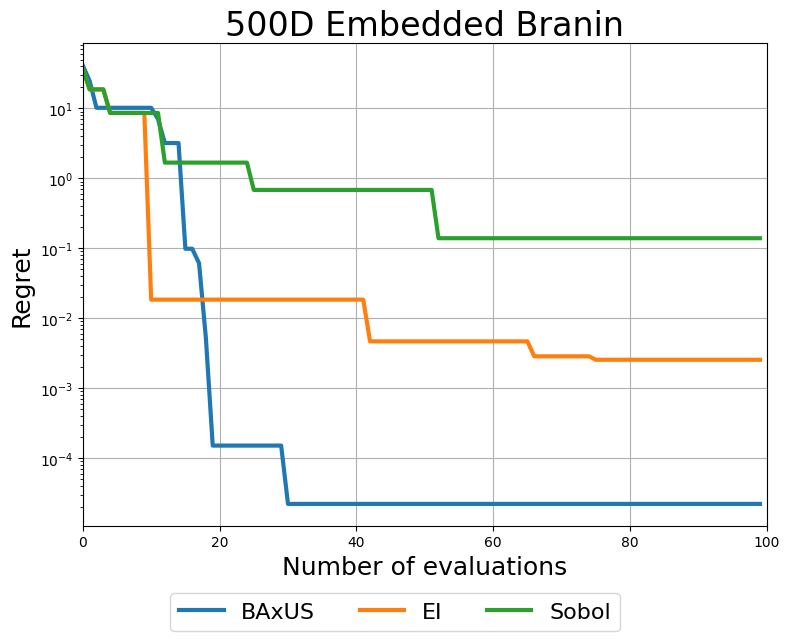

In [15]:
%matplotlib inline

names = ["BAxUS", "EI", "Sobol"]
runs = [Y_baxus, Y_ei, Y_Sobol]
fig, ax = plt.subplots(figsize=(8, 6))

for name, run in zip(names, runs):
    fx = np.maximum.accumulate(run.cpu())
    plt.plot(-fx + branin.optimal_value, marker="", lw=3)

plt.ylabel("Regret", fontsize=18)
plt.xlabel("Number of evaluations", fontsize=18)
plt.title(f"{dim}D Embedded Branin", fontsize=24)
plt.xlim([0, len(Y_baxus)])
plt.yscale("log")

plt.grid(True)
plt.tight_layout()
plt.legend(
    names + ["Global optimal value"],
    loc="lower center",
    bbox_to_anchor=(0, -0.08, 1, 1),
    bbox_transform=plt.gcf().transFigure,
    ncol=4,
    fontsize=16,
)
plt.show()